In [2]:
#default_exp ensemble

In [3]:
#hide
from nbdev.showdoc import *

In [41]:
#hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dev comments

Project definitions:

- Set a method called dfit or overwrite fit method in order to have sklearn pipeline support?
- Delegates for an instance of estimator inside class or increment classes through factories (better support in sklearn pipelines)?


- [X] TODO: Solve Tree Predict mistery
- [ ] TODO: make gaussian process interface
- [ ] TODO: make meta bagged randomized prior class
- [ ] TODO: make a multivariate joint dist estimator for AdaBoostingRegressor

- [X] TODO: make boosting and baging tree estimator classes
- [X] TODO: implement bagging and boosting meta estimator (include sampling from sub models)
- [X] TODO: include target scaling in pipeline
- [ ] TODO: make a "density" method, that returns a RandomVariable class
- [ ] TODO: Create DensityEstimator Base Class containing sample and density methods (density calls sample and returns RV CLASS)
- [ ] TODO: Mean, Variance and Entropy explainer tool (LIME, SHAP, foressts...)
- [X] TODO: Decide wether to allow multi output (doesnt model well multivariate bimodal joint probabilities, cheeky to sample (two different random samples))
- [ ] Implement KNN estimator
- [ ] Entropy based regression with random forest embeddings + entropy of targets in each node

- [ ] Learn how to implement entropy estimation in cython and set it as a possible splitting criteria

# Ensemble density estimators -

Density estimators based on ensemble methods, such as baging, boosting and some decision tree algorithms. All 'classes' are actually factories that dinamically extends the funcitonality of the original sklearn class with methods such as sample.

In [947]:
#export
from warnings import warn
from functools import partial
import copy
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder, normalize, QuantileTransformer, FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils.fixes import _joblib_parallel_args
import scipy
from joblib import Parallel, delayed


from scikit_density.utils import cos_sim_query, sample_multi_dim, ctqdm, DelegateEstimatorMixIn
from scikit_density.core.random_variable import KDE

# Example data

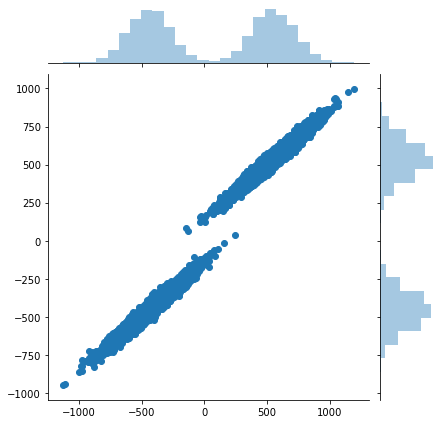

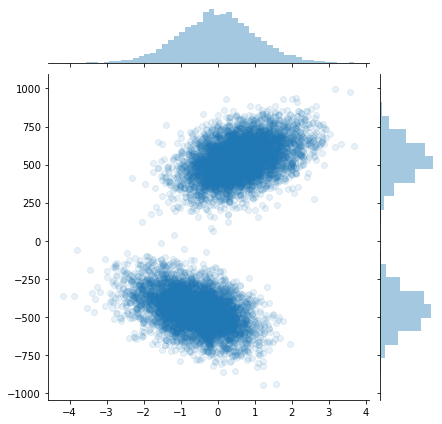

In [859]:
import seaborn as sns
from sklearn.datasets import make_regression

def sigmoid(x):
    return 1/(1+np.exp(x))

X,y = make_regression(
    n_samples=10000,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=2,
    noise=0.2,
    shuffle=True,
    coef=False,
    random_state=None
)


#make one of X[1] feature mode weightening
bimodal_factor_wieght = 2
bimodal_factors = (1-sigmoid(bimodal_factor_wieght*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
bimodal_factors[bimodal_factors == 0] = -1
bimodal_factors = bimodal_factors.reshape(-1,1)

y = bimodal_factors*y

sns.jointplot(y[:,0],y[:,1])

sns.jointplot(X[:,-1], y[:,1], alpha = 0.1)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(X))], y[int(0.8*len(X)):]

# MultiOutputRegressor (Move to skdensity.meta and fix sampling problem)

In [861]:
class EnsembleMultiOutputEstimator(MultiOutputRegressor):
    '''Custom multioutput for multioutput cases except random forests (which handles multi output directly)'''
    def apply(self,X):
        result = [estim.apply(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)
    def sample(self, X, sample_size = 10, weights = None):        
        result = np.array([estim.sample(X, sample_size = sample_size, weights = weights) for estim in self.estimators_])
        result = np.swapaxes(result,0,1)
        result = np.swapaxes(result,1,2)
        return result

# Ensemble Tree methods

## Ensemble tree mixin class
>creates some functionalities for similarity sampling based random forests and naive sampling random forests

In [1032]:
#export


#node quality functions
def expected_likelihood(node_data, sample_size = 100):
    kde = KDE().fit(node_data)    
    return np.mean(kde.pdf(kde.rvs(size = sample_size)))

def inverese_log_node_var(node_data):    
    return 1/np.log1p(np.var(node_data))


# datapoint-node functions
def datapoint_pdf(node_data):
    return KDE().fit(node_data).pdf(node_data)

def datapoint_gaussian_likelihood(node_data):
    std = node_data.std()
    mean = node_data.mean()
    z = (node_data - mean)/std
    return 1/(std*np.pi**(1/2))*np.exp(-1/2*z**2)


AVALIBLE_NODE_AGG = {
    'expected_likelihood':expected_likelihood,
    'inverse_log_variance':inverese_log_node_var,
}

AVALIBLE_DATAPOINT_WEIGHT_FUNC = {
    'kde_likelihood': datapoint_pdf,
    'gaussian_likelihood': datapoint_gaussian_likelihood
}

In [1168]:
#export
class EnsembleTreesDensityMixin():    
    
    '''Base Class containing important methods for building Naive and Similarity Density Tree estimators'''
    
    def _fit_leaf_node_matrix(self, X, y, node_rank_func, node_data_rank_func):
        nodes_array = self.estimator.apply(X)
        encoder = OneHotEncoder()
        leaf_node_matrix = encoder.fit_transform(nodes_array)
        leaf_node_matrix = self._make_weighted_query_space(y, leaf_node_matrix, node_data_rank_func)
        
        self.leaf_node_weights = self._calculate_node_weights(y, leaf_node_matrix, node_rank_func)        
        self.leaf_node_matrix = leaf_node_matrix
        self.encoder = encoder
        return self

    def _transform_query_matrix(self, X):
                
        return  self._make_weighted_query_vector(
            agg_node_weights = self.leaf_node_weights,
            node_matrix = self.encoder.transform(self.estimator.apply(X)))
        
    
    def _query_idx_and_sim(self, X, n_neighbors, lower_bound, beta, gamma):        
        idx, sim = cos_sim_query(
            self._transform_query_matrix(X), self.leaf_node_matrix, n_neighbors=n_neighbors,
            lower_bound=lower_bound, beta = beta, gamma = gamma)        
        return idx, sim
    
    def _similarity_sample(self, X, sample_size = 100, weights = None, n_neighbors = 10,
                           lower_bound = 0.0, alpha = 1, beta = 0, gamma = 0):
        
        idx, sim = self._query_idx_and_sim(X ,n_neighbors=n_neighbors, lower_bound=lower_bound,beta = beta, gamma = gamma)                
        idx, sim = np.array(idx), np.array(sim)
        
        p = self._handle_sample_weights(weight_func = weights, sim = sim, alpha = alpha)        
        samples = []
        for i in range(len(idx)):            
            samples.append(self.y_[sample_multi_dim(idx[i], size = sample_size, weights = p[i], axis = 0)])
            
            #sampled_idxs = np.random.choice(idx[i], size = sample_size, replace = True, p = p[i])
            #samples.append(self.y_[sampled_idxs])
        
        return np.array(samples)
    
    def _similarity_empirical_pdf(self, X, weights, n_neighbors, lower_bound, alpha, beta, gamma):
        
        idx, sim = cos_sim_query(
            self._transform_query_matrix(X),
            self.leaf_node_matrix,
            n_neighbors=n_neighbors,
            lower_bound=lower_bound,
            beta = beta,
            gamma = gamma)
        p = self._handle_sample_weights(weight_func = weights, sim = sim, alpha = alpha)
        return np.array([self.y_[i] for i in idx]), p
    
    def _sim_predict(self, X, weights, n_neighbors, lower_bound, alpha, beta, gamma):                
        '''wieghts must be None or callable that operates on similarity values'''

        values, weights = self._similarity_empirical_pdf(X, weights, n_neighbors, lower_bound, alpha, beta, gamma)
        
        y_multioutput = (len(values.shape) - 1) > 1
        if y_multioutput:
            y_dim = values.shape[-1]
            weights = np.repeat(weights, y_dim, axis = -1).reshape(*weights.shape, y_dim)
            return np.average(values, weights = weights, axis = -2)    
        else:
            return np.average(values, weights = weights, axis = -1)

    def _calculate_node_weights(self, y, node_matrix, node_rank_func):
        '''
        calculates node weights that maultiplies the query space matrix, in order to make some nodes more relevant
        according to some target data node agg metric.
        input should be a list containing array of node samples as each one of its elements
        '''        
        
        if not node_rank_func is None:
            node_data_generator = self._make_node_data_generator(y, node_matrix)        
            # cannot call in a vectorized fashion because data from nodes may have different sizes
            if callable(node_rank_func):
                pass            
            else:
                node_rank_func = AVALIBLE_NODE_AGG[node_rank_func]                    

            node_weights = Parallel(n_jobs=-1, verbose=0,
                               **_joblib_parallel_args(prefer="threads"))(
                delayed(node_rank_func)(X)
                for X in node_data_generator)
        else:
            node_weights = np.ones(node_matrix.shape[1])                
        
        return np.array(node_weights)
    
    def _calculate_node_datapoint_weights(self, y, node_matrix, node_data_rank_func):
        '''
        Calculates node-datapoint(y values) weights. higher values meansa datapoint "belongs tighter" 
        to that point and is more loleky to be sampled when that node is reached. some cases of node-datapount wieghts
        could be the likelihood of that point given the node pdf, or some sort of median/mean deviance from point to node samples
        '''
        #
        if callable(node_data_rank_func):
            pass
        else:
            node_data_rank_func = AVALIBLE_DATAPOINT_WEIGHT_FUNC[node_data_rank_func]
        
        node_data_generator = self._make_node_data_generator(y, node_matrix)        
        #datapoint_node_weights = Parallel(n_jobs=1, verbose=0,
        #                   **_joblib_parallel_args(prefer="threads"))(
        #    delayed(node_data_rank_func)(X)
        #    for X in node_data_generator)
        
        datapoint_node_weights = [node_data_rank_func(node_data) for node_data in node_data_generator]
        return datapoint_node_weights
    
    def _make_node_data_generator(self, y, node_matrix):        
        nodes = node_matrix.tocoo().col
        idxs = node_matrix.tocoo().row
        return (y[idxs[nodes == i]] for i in tqdm([*range(node_matrix.shape[1])]))

    def _handle_sample_weights(self, weight_func, sim, alpha):
        '''
        sampling wights should sum to 1, since its a sampling probability
        '''
        if weight_func is None:                        
            return np.array([normalize((i**alpha).reshape(1,-1) + 1e-9, norm = 'l1').flatten() for i in sim])
        else:
            return np.array([normalize((weight_func(i)).reshape(1,-1) + 1e-9, norm = 'l1').flatten() for i in sim])
    
    def _make_weighted_query_vector(self, agg_node_weights, node_matrix):
        '''
        multiplies elements of query vector by their respective weights
        the greater the weights, the better the "quality" of the nodes
        '''        
        assert isinstance(node_matrix, scipy.sparse.csr_matrix), 'input should be instance of scipy.sparse.csr_matrix'                
        node_matrix.data = node_matrix.data*np.take(agg_node_weights, node_matrix.indices)         
        return node_matrix
    
    def _make_weighted_query_space(self, y, node_matrix, node_data_rank_func = None):
        '''
        query space is the leaf_node_matrix multiplied by node_data_weights
        the greater the value in the matrix, the better the "quality" of that data point
        '''
        assert isinstance(node_matrix, scipy.sparse.csr_matrix), 'input should be instance of scipy.sparse.csr_matrix'
        
        if not node_data_rank_func is None:
            # datapoint_node_weights multiplication (columns)
            #make copy
            node_matrix = copy.deepcopy(node_matrix)
            #cast to csc to make .data order columnwise
            node_matrix = node_matrix.tocsc()
            datapoint_node_weights = self._calculate_node_datapoint_weights(y, node_matrix, node_data_rank_func)
            node_matrix.data = node_matrix.data*np.concatenate(datapoint_node_weights)        
            #convert back to csr
            node_matrix = node_matrix.tocsr()
        else:
            pass
        
        return node_matrix
        

#WEIGHTS ARE TO SMALL, SCALE BEFORE MULTIPLY
        

In [1169]:
node_matrix

<8000x3779 sparse matrix of type '<class 'numpy.float64'>'
	with 80000 stored elements in Compressed Sparse Row format>

## ForestSimilarityEstimator - 

Estimates the conditional distribution based on samples from dataset taking into account the `leaf_node_matrix`

In [1170]:
#export
    
class SimilarityTreeEnsemble(EnsembleTreesDensityMixin):

    def __init__(self, estimator, alpha = 1, beta = 1, gamma = 1, node_rank_func = 'expected_likelihood',
                 node_data_rank_func = 'kde_likelihood',n_neighbors = 30, lower_bound = 0.0):
        
        self.estimator = estimator
        self.n_neighbors = n_neighbors
        self.lower_bound = lower_bound
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.node_rank_func = node_rank_func
        self.node_data_rank_func = node_data_rank_func
        return

    def __repr__(self):
        return self.__class__.__name__

    def fit(self, X, y = None):        
        self.estimator.fit(X,y)
        self._fit_leaf_node_matrix(
            X, y, node_rank_func = self.node_rank_func, node_data_rank_func = self.node_data_rank_func)# <- MAKE NODE WIEGHTED VERSION
        self.y_ = y
        return self

    def sample(self, X, sample_size = 10, weights = None, n_neighbors = None,
               lower_bound = None, alpha = None, beta = None, gamma = None):
        '''wieghts should be callable (recieves array returns array of same shape) or None'''
        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(n_neighbors, lower_bound,
                                                                                    alpha, beta, gamma)

        return super()._similarity_sample(
            X = X, sample_size = sample_size, weights = weights, n_neighbors = n_neighbors,
            lower_bound = lower_bound, alpha = alpha, beta = beta, gamma = gamma
        )

    def sim_predict(self, X, weights = None, n_neighbors = None, lower_bound = None, alpha = None, beta = None, gamma = None):
        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(n_neighbors, lower_bound, alpha, beta, gamma)
        return self._sim_predict(X, weights, n_neighbors, lower_bound, alpha, beta, gamma)

    def _handle_similarity_sample_parameters(self, n_neighbors, lower_bound, alpha, beta, gamma):

        if n_neighbors is None:
            n_neighbors = self.n_neighbors
        if lower_bound is None:
            lower_bound = self.lower_bound
        if alpha is None:
            alpha = self.alpha
        if beta is None:
            beta = self.beta
        if alpha is None:
            gamma = self.gamma

        return n_neighbors, lower_bound, alpha, beta, gamma

We can see that forest estimators are better in dealing with bimodal data

In [1171]:
estimator = ensemble.ExtraTreesRegressor(n_estimators = 10,min_samples_leaf = 15, warm_start = False)
density_estimator = SimilarityTreeEnsemble(estimator).fit(X_train,y_train[:,:])

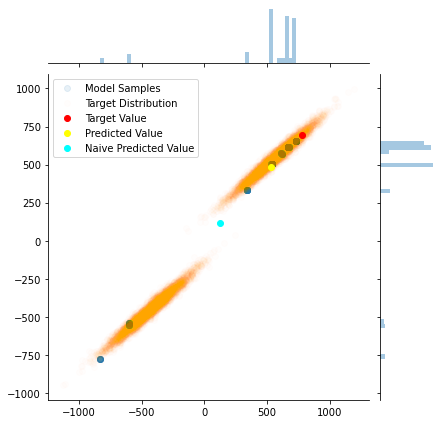

In [1208]:
#i += 5

alpha, beta, gamma = 10,10,10
samples = density_estimator.sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta, gamma = gamma)
prediction = density_estimator.sim_predict(X_test[i:i+1], alpha = alpha, beta = beta, gamma = gamma)
naive_prediction = density_estimator.estimator.predict(X_test[i:i+1])

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
    
    
    
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

## ExtremelyRandomizedEntropyTree - 
> A tree that predicts based on entropy-weighted query of representation vector (leaf nodes), good for mutlimodal data

two kinds of weights:
global node weight  = entropy of the node (y distribution)
node-sample weight = likelihood of y in the node distribution (kde, normal, lognormal, whatever)

node wieght -> multiplies column of one hot vectorized array after forest.apply
sample-node weight - > likelyhood of that point in that node

maybe node wieght doesnt make sense since a distribution with high entropy yields on low likelihoods

method 1:

set likelihood weights for each sample-node pair and define query space as a sparse wighted matrix.
then turing inference, query wieghted samples from query_space just like in sim tree.

method 2:

set distribution of each node, then during inference, draw samples from each node distribution. then, from all the sampled nodes, sample according to node entropy.

for peformance sake in inference time, user can define topn (sored by lowest entropy) explanatory nodes and sample from then according to their weights

set entropy threshold just to ensure only a few usefull nodes are reached.

user can define arbitrary prior distribution to nodes, although default is kde

#########################################################################################
appart from similarity factor $\alpha$, include node relevance factor $\beta$  in order to have $(\frac{NodeAggMetric}{NodeAggMetric_{max}})^\beta$ as node multipliers in the node - data adjacency matrix. NodeAggMetric could be variance, entropy, or user dfined metric, such as likelihood to some distribution.

then sample according to $CosSim(A,B)^\alpha$

May include KDE sampling for nodes, depending on ammount of nodes

make this framework default for every DensityTree (NaiveTree is a special case for alpha = 0 and beta = 0)

In [870]:
class LikelihoodTreeEstimator(ensemble.RandomTreesEmbedding):
    
    def __init__(self,):
        pass
    
    def _get_node_data(self,):
        '''
        get the y values of a node
        '''
        y_msk_ith_node = embeddings[:,i].astype(bool)
        ith_node_data = self.y_[y_msk_ith_node]
        pass
    
    def _fit_node_dist(self,):
        '''
        fit y distibution to a specified distribution
        '''
        
        pass
    
    def _calc_y_likelihood(self,):
        '''
        evaluate likelihood for each y datapoint in its distribution and assign
        it as a weight to the node column
        '''
        likelihoods = ith_fitted_dist.evaluate(y)
        
        pass
    
    def _multiply_embeddings_by_weights(self,):
        '''
        
        '''
        embeddings.data = embeddings.data*self.likelihood_weights
        self.query_space = embeddings

# ConditionalMultimodalTest - 
> A multimodal test performed with datapoints close in a feature representation space in random forests

# Bimodal Estimator

An estimator that normalizes the data, predicts the absolute value of y, then with the predicted value and the the features, try to predict the signal of the prediction

# Meta Estimators (Bagging, Boosting, Stacking)

## BaggingDensityEstimator

In [95]:
#export
def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return np.array([estimator.predict(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features)])

class BaggingDensityEstimator(ensemble.BaggingRegressor):
    
    def sample(self, X, sample_size = 10, weights = None):
        idxs = self._sample_idxs(X, sample_size, weights)
        predictions = self._predict_all_estimators(X)
        return self._sample_from_idxs(predictions, idxs)        
        
    def _predict_all_estimators(self, X):    
        ensemble._bagging.check_is_fitted(self)
        # Check data
        X = ensemble._bagging.check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        # Parallel loop
        n_jobs, n_estimators, starts = ensemble._bagging._partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_y_hat = ensemble._bagging.Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            ensemble._bagging.delayed(_parallel_predict_regression)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X)
            for i in range(n_jobs))

        predictions = np.swapaxes(all_y_hat[0], 0, 1)
        return predictions
    
    def _sample_from_idxs(self, predictions, idxs):        
        return np.array([predictions[i][idxs[i]] for i in range(len(idxs))])
    
    def _sample_idxs(self, X, sample_size, weights):
        '''Sample indxs according to estimator weights'''
        return [np.random.choice([*range(self.n_estimators)], size = sample_size, p = weights) for i in range(X.shape[0])]
            

The BaggingDensityEstimator is an extension of sklearn BaggingRegressor that allows sampling from each isntance of base estimator. We can bag Linear Regressors for example

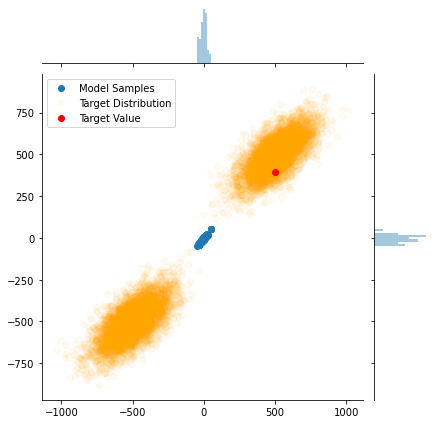

In [96]:
from sklearn.linear_model import LinearRegression
estimator = LinearRegression()
density_estimator = BaggingDensityEstimator(estimator, n_estimators = 100, max_samples = 0.2, max_features = 0.2).fit(X,y)

samples = density_estimator.sample(X_test[0:1], sample_size = 100)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples'})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

We can combine with the TransformedTargetEstimator to transform the output space before regression

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass transformer=QuantileTransformer(output_distribution='normal') as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


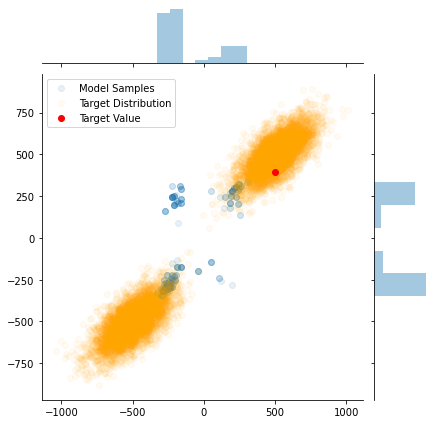

In [99]:
from sklearn.compose import TransformedTargetRegressor

estimator = TransformedTargetRegressor(LinearRegression(), QuantileTransformer(output_distribution = 'normal'))
density_estiamtor = BaggingDensityEstimator(estimator, n_estimators = 100, max_samples = 0.3,max_features = 0.3).fit(X,y)

samples = density_estiamtor.sample(X_test[0:1], sample_size = 300)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

## AdaBoostDensityEstimator

In [100]:
#export
class AdaBoostDensityEstiamtor(ensemble.AdaBoostRegressor):
    
    def sample(self, X, sample_size = 10, weights = 'boosting_weights'):
        idxs = self._sample_idxs(X, sample_size, weights)
        predictions = self._predict_all_estimators(X)
        return self._sample_from_idxs(predictions, idxs)
    
    def _predict_all_estimators(self, X):    
        return np.array([est.predict(X) for est in self.estimators_[:len(self.estimators_)]]).T
    
    def _sample_from_idxs(self, predictions, idxs):
        return np.array([predictions[i][idxs[i]] for i in range(len(idxs))])
    
    def _sample_idxs(self, X, sample_size, weights):
        '''Sample indxs according to estimator weights'''        
                        
        if weights is None:
            weights = np.ones(sample_size)[:len(self.estimators_)]
            weights /= weights.sum()
            
        elif weights == 'boosting_weights':
            weights = self.estimator_weights_[:len(self.estimators_)]
            weights /= weights.sum()            
        else:
            weights = self.estimator_weights_[:len(self.estimators_)]*weights
            weights /= weights.sum()        
            
        idxs = [np.random.choice([*range(len(self.estimators_))], size = sample_size, p = weights) for i in range(X.shape[0])]
        return idxs
        
        

AdaBoostDensityEstimator suports only single output tasks. you can use CustomMultiOutputRegressor, but since it will fit each output dimension separetly, you have a decent prediction for the marginal distributions but not for the joint distribution.

For this reason, AdaBoostEstimator is not recomended for multivariate density estimation

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass transformer=QuantileTransformer() as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


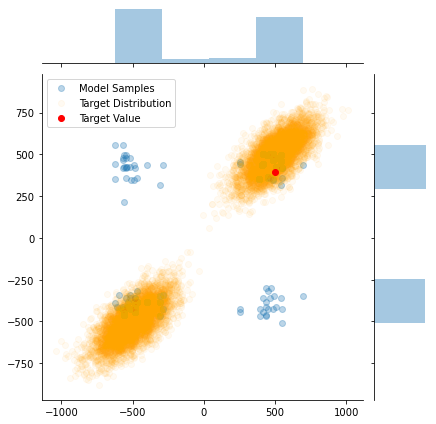

In [102]:
from sklearn.tree import DecisionTreeRegressor
estimator = AdaBoostDensityEstiamtor(TransformedTargetRegressor(DecisionTreeRegressor(),QuantileTransformer()), learning_rate = 0.01)
multioutput_estimator = EnsembleMultiOutputEstimator(estimator)
density_estimator = multioutput_estimator.fit(X_train, y_train)

samples = density_estimator.sample(X_test[0:1], sample_size = 100)

jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.3})
jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.05, label = 'Target Distribution')
jntplot.ax_joint.scatter(y_test[0,0], y_test[0,1], color = 'red', label = 'Target Value')

jntplot.ax_joint.legend()

We can see that for 1d estimation it works quite well

In [ ]:
import matplotlib.pyplot as plt
estimator = DecisionTreeRegressor()
density_estimator = AdaBoostDensityEstiamtor(estimator, learning_rate = 0.1).fit(X_train, y_train[:,0])

samples = density_estimator.sample(X_test[0:1], sample_size = 100)

sns.distplot(samples)
sns.distplot(y_train[:,0])
plt.axvline(y_test[0,0], color = 'r')


## StackingDensityEstimator
> Allows for stacking while making the input of last layer as a sample of last estimators samples

In [ ]:
t = StackingDensityEstimator()
e1 = BaggingDensityEstimator(TransformedTargetEstimator(LinearRegression)(), n_estimators = 10, max_samples = 0.2,max_features = 0.2).fit(X,y)
e2 = BaggingDensityEstimator(LinearRegression(), n_estimators = 10).fit(X,y)

t([('e1',e1),('e2',e2)],e1).fit(X_train,y_train[:,1])

In [ ]:
#from sklearn import ensemble
ens = ensemble.StackingRegressor(('l1',ensemble.RandomForestRegressor()), enesemble.RandomForestRegressor())

In [ ]:
ens.fit(X_train, y_train)

# Export -

In [942]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_ensemble.ipynb.
Converted 02_core.random_variable.ipynb.
Converted 03_utils.ipynb.


[autoreload of scikit_density.core.random_variable failed: Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "..\scikit_density\core\random_variable.py", line 280
    class RVArray():
     